# GFS usage example

GFS is one most well known weather forecast models and it's data is free for everyone to use. 

This notebook illustrates ways of using GFS model data via Planet OS API, including: 

1. point and raster API options
2. explanation, why we provide different data aggregation periods, including some analysis of numerical accuracy
3. examples for parameters related to wind and solar energy, like wind speed and solar radiation

API documentation is available at http://docs.planetos.com. If you have questions or comments, join the Planet OS Slack community to chat with our development team.
For general information on usage of IPython/Jupyter and Matplotlib, please refer to their corresponding documentation. https://ipython.org/ and http://matplotlib.org/

First, you have to define usable API endpoint, which consists of server name, dataset name, API key and query details. 
It is necessary to provide location details, for point API single point and raster API, four courners.

In [35]:
%matplotlib notebook
import urllib.request
import numpy as np
import simplejson as json
import pandas as pd
from netCDF4 import Dataset, date2num, num2date
import ipywidgets as widgets
from IPython.display import display
import dateutil.parser
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import time

<font color='red'>Please put your datahub API key into a file called APIKEY and place it to the notebook folder or assign your API key directly to the variable API_key!</font>

In [36]:
API_key = open('APIKEY').read().strip()
longitude = 27.5
latitude  = 58.8
longitude_west = 12
longitude_east = 43
latitude_south = 49
latitude_north = 68
dataset_key = "noaa_gfs_pgrb2_global_forecast_recompute_0.25degree"
server = "http://api.planetos.com/v1/datasets/"

Let's define some help functions for generating point API and raster API queries

In [37]:
def generate_point_api_query(server=server, dataset_key=dataset_key, longitude=longitude, latitude=latitude, count=10, API_key=API_key, z='all', **kwargs):
    returl = server + dataset_key + "/point?lat={0}&lon={1}&apikey={2}&count={3}&z={4}".format(latitude,longitude,API_key,count,z)
    for i,j in kwargs.items():
        returl += "&{0}={1}".format(i,j)
    print(returl)
    return returl
        
def generate_raster_api_query(server=server, dataset_key=dataset_key, longitude_west=longitude_west, latitude_south=latitude_south, longitude_east=longitude_east, latitude_north=latitude_north, count=10, API_key=API_key, **kwargs):
    returl = server + dataset_key + "/area?apikey={0}&polygon=[[{1},{3}],[{2},{3}],[{2},{4}],[{1},{4}],[{1},{3}]]&grouping=location&count={5}&reftime_recent=true".format(API_key,longitude_west,longitude_east,latitude_south,latitude_north,count)
    for i,j in kwargs.items():
        returl += "&{0}={1}".format(i,j)
    print(returl)
    return returl

def read_data_to_json(req_url):
    return json.loads(urllib.request.urlopen(req_url).read().decode('utf-8'))['entries']

## Point data API

By _point data_ we mean data that is given at a single point (or from single measurement device) at different timesteps. For forecasts, like GFS, which has global coverage, this means selection of one single geographic point and getting data for one or more parameters. To follow the examples better, we suggest to pay attention to following API keywords, which may not seem obvious in first place:

1. count -- how many values for particular context (set of spatial and temporal dimensions) are returned
2. z -- selection of vertical levels 

In [38]:
point_url = generate_point_api_query()

http://api.planetos.com/v1/datasets/noaa_gfs_pgrb2_global_forecast_recompute_0.25degree/point?lat=58.8&lon=27.5&apikey=8428878e4b944abeb84790e832c633fc&count=10&z=all


Now let's actually download the data and load JSON to python dictionary

In [39]:
point_data = json.loads(urllib.request.urlopen(point_url).read().decode('utf-8'))['entries']

While the returned JSON data format is already easy to understand, we prefer to use Pandas dataframes for easier data plotting both for tables and graphs, but you do not need to learn Pandas to use the data, basic knowledge of Numpy should be sufficient.

In [40]:
def convert_json_to_some_pandas(injson):
    param_list = ['axes','data']
    new_dict = {}
    [new_dict.update({i:[]}) for i in param_list]
    [(new_dict['axes'].append(i['axes']),new_dict['data'].append(i['data'])) for i in injson];
    pd_temp = pd.DataFrame(injson)
    dev_frame = pd_temp[['context','axes']].join(pd.concat([pd.DataFrame(new_dict[i]) for i in param_list],axis=1))
    dev_frame = dev_frame[dev_frame['reftime'] == dev_frame['reftime'][0]]
    return dev_frame

In [41]:
point_data_frame = convert_json_to_some_pandas(point_data)

In [42]:
point_data_frame

,context,axes,latitude,longitude,potential_vorticity_surface,reftime,sigma,sigma_layer,time,z,...,vratepbl,vstm6000_0m,vvelprs,vvelsig,vwsh2pv,vwshtrop,watrsfc_1_Hour_Accumulation,watrsfc_3_Hour_Accumulation,weasdsfc,wiltsfc
0,reftime_time3_lat_lon,"{'reftime': '2018-07-04T00:00:00', 'time': '20...",58.75,27.5,NaN,2018-07-04T00:00:00,NaN,NaN,2018-07-04T03:00:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,reftime_time3_lat_lon,"{'reftime': '2018-07-04T00:00:00', 'time': '20...",58.75,27.5,NaN,2018-07-04T00:00:00,NaN,NaN,2018-07-04T06:00:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9999.0,NaN,NaN
2,reftime_time3_lat_lon,"{'reftime': '2018-07-04T00:00:00', 'time': '20...",58.75,27.5,NaN,2018-07-04T00:00:00,NaN,NaN,2018-07-04T09:00:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,reftime_time3_lat_lon,"{'reftime': '2018-07-04T00:00:00', 'time': '20...",58.75,27.5,NaN,2018-07-04T00:00:00,NaN,NaN,2018-07-04T12:00:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9999.0,NaN,NaN
4,reftime_time3_lat_lon,"{'reftime': '2018-07-04T00:00:00', 'time': '20...",58.75,27.5,NaN,2018-07-04T00:00:00,NaN,NaN,2018-07-05T03:00:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,reftime_time3_lat_lon,"{'reftime': '2018-07-04T00:00:00', 'time': '20...",58.75,27.5,NaN,2018-07-04T00:00:00,NaN,NaN,2018-07-05T06:00:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9999.0,NaN,NaN
6,reftime_time3_lat_lon,"{'reftime': '2018-07-04T00:00:00', 'time': '20...",58.75,27.5,NaN,2018-07-04T00:00:00,NaN,NaN,2018-07-05T09:00:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,reftime_time3_lat_lon,"{'reftime': '2018-07-04T00:00:00', 'time': '20...",58.75,27.5,NaN,2018-07-04T00:00:00,NaN,NaN,2018-07-05T12:00:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9999.0,NaN,NaN
8,reftime_time3_lat_lon,"{'reftime': '2018-07-04T00:00:00', 'time': '20...",58.75,27.5,NaN,2018-07-04T00:00:00,NaN,NaN,2018-07-05T15:00:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,reftime_time3_lat_lon,"{'reftime': '2018-07-04T00:00:00', 'time': '20...",58.75,27.5,NaN,2018-07-04T00:00:00,NaN,NaN,2018-07-05T18:00:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9999.0,NaN,NaN


Now when you look at the data, you can see that it contains many variables, which are divided into contexts. Context here means just a set of spatial and temporal dimensions for particular variable, like NetCDF dimensions. GFS is a complex model with large amount of variables and at first glance such a view may be a bit confusing, considering that each variable has values only in one context. So the NaN's do not come from the API request, but from the current way we use to create the Dataframe. It is not difficult to filter out variables from the dataframe, but for any use case besides observing the data, it is more reasonable to query only the right data from the server. But how do you know, what variables are right for you? It is possible to observe variable list at dataset detail page http://data.planetos.com/datasets/noaa_gfs_pgrb2_global_forecast_recompute_0.25degree but is there an easier, more automated way?

One option is to get variable list directly from detail API

In [43]:
def get_variables_from_detail_api(server=server,dataset_key=dataset_key,API_key=API_key):
    req = urllib.request.urlopen("{0}{1}?apikey={2}".format(server, dataset_key, API_key))
    data = json.loads(req.read().decode('utf-8'))
    return [i for i in data['Variables'] if i['isData']]

In [44]:
variables = get_variables_from_detail_api()

Now, when we have a usable list of variables, we demonstrate a simple way for variable selection and plotting. It makes great sense to separate variable selection into two phases, first the vertical level type and then actual variable, because most people are actually not interested in values given at top of the atmosphere or sigma levels.

In [45]:
levelset=set([i['longName'].split("@")[1] for i in variables])
vardict = {}
for i in levelset:
    vardict[i] = []
for i in variables:
    varname, varlevel = i['longName'].split("@")
    vardict[varlevel].append(varname)

Here we define two drop-down menus for first selecting the vertical level type and second variable, which is available for these vertical levels.

In [46]:
def get_sample_var_name(variables, selected_variable, selected_level):
    ## The human readable variable name is not the same as the compact one in API request
    return [i['name'] for i in variables if i["longName"] == selected_variable + "@" + selected_level][0]

droplist = list(levelset)

selecter = widgets.Dropdown(
        options=droplist,
        value=droplist[0],
        description='Select level type:',
        disabled=False,
        button_style='' # 'success', 'info', 'warning', 'danger' or ''
    )
selecter2 = widgets.Dropdown(
        options=sorted(vardict[selecter.value]),
        value=vardict[selecter.value][0],
        description='Select variable:',
        disabled=False,
        button_style='' # 'success', 'info', 'warning', 'danger' or ''
    )

def select_from_list2(sender):
    selecter2.options = vardict[selecter.value]
    
selecter.observe(select_from_list2)
display(selecter)
display(selecter2)

Once selected, you do not have to specify variable name any more, just executing following section should be enough to make the plot. 

We suggest trying to plot at least following data: 

1. wind speed at specified height above ground (to illustrate the vertical coordinate)
2. some variable with 1h and 3h aggregation periods (this will show how 1h aggregation is given for five day period and 3h aggregation for 10 day period, for example downward short-wave radiation

The wind speed at 80m height and surface solar radiation are also main variables interesting for renewable energy production.

You have to be careful with variable vertical coordinate, as some variables have more that one and this is usually specified with the 'z' in dataframe.
Following section will plot each level from data separately, if more than one level exists.

http://api.planetos.com/v1/datasets/noaa_gfs_pgrb2_global_forecast_recompute_0.25degree/point?lat=58.8&lon=27.5&apikey=8428878e4b944abeb84790e832c633fc&count=100000&z=all&var=tcdcblcll_1_Hour_Average


<IPython.core.display.Javascript object>


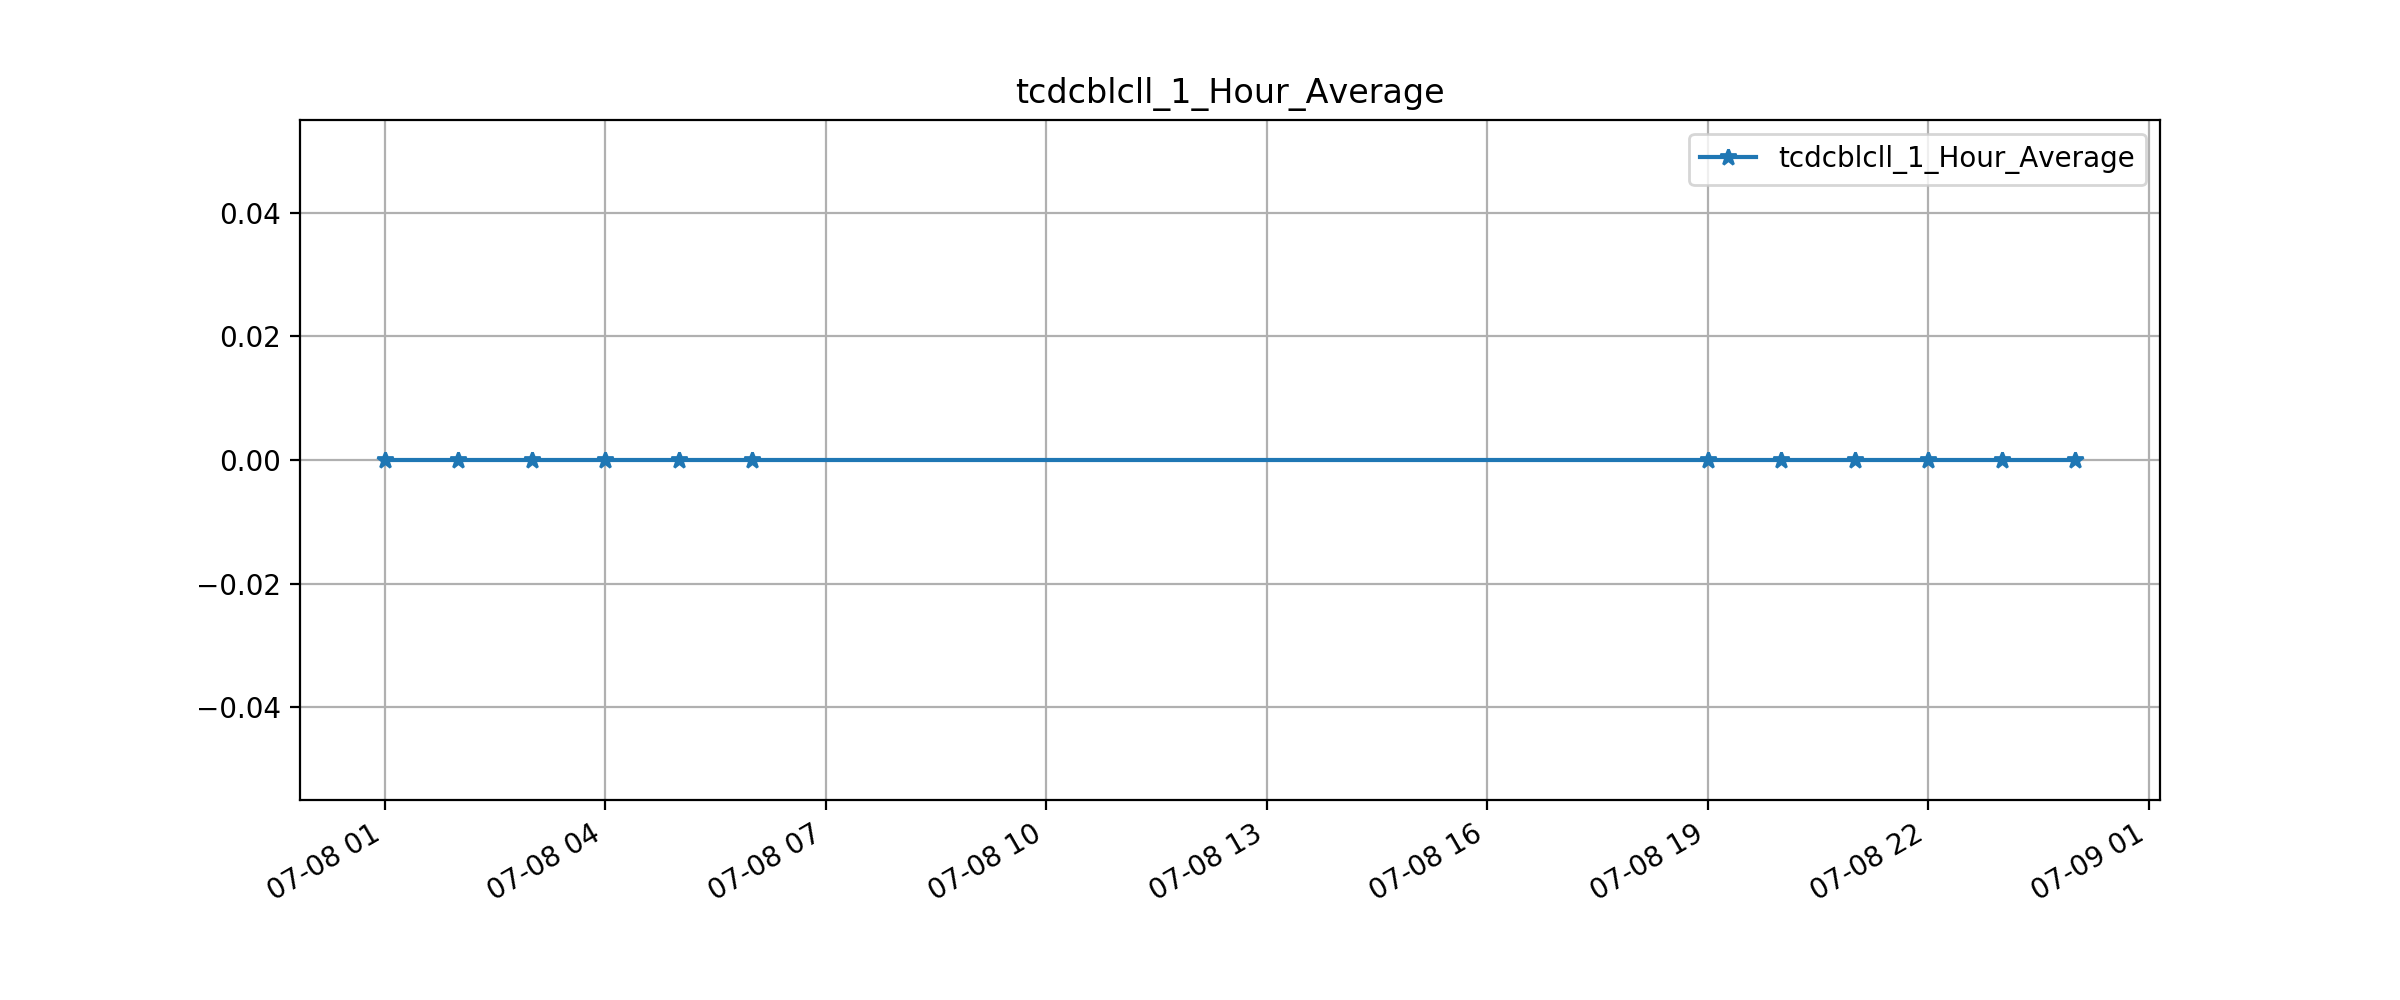

In [47]:
sample_var_name = get_sample_var_name(variables, selecter2.value, selecter.value)
sample_point_data_json = read_data_to_json(generate_point_api_query(**{'var':sample_var_name,'count':100000}))
sample_point_data_pd = convert_json_to_some_pandas(sample_point_data_json)

fig = plt.figure(figsize=(12,5))
## find how many vertical levels we have
if 'z' in sample_point_data_pd:
    zlevels = sample_point_data_pd['z'].unique()
    if len(zlevels) != 1:
        print("Warning: more than one vertical level detected ", zlevels)
    ##fig = plt.figure(figsize=(20,10))
    for i in zlevels:
        pdata=np.array(sample_point_data_pd[sample_point_data_pd['z']==i][sample_var_name],dtype=np.float)
        if np.sum(np.isnan(pdata))!=pdata.shape[0]:
            plt.plot(sample_point_data_pd[sample_point_data_pd['z']==i]['time'].apply(dateutil.parser.parse),pdata,label=i)
        else:
            print("Cannot plot all empty values!")
else:
    pdata = np.array(sample_point_data_pd[sample_var_name],dtype=np.float)
    if np.sum(np.isnan(pdata))!=pdata.shape[0]:
        plt.plot(sample_point_data_pd['time'].apply(dateutil.parser.parse), pdata, '*-', label=sample_var_name)      
    else:
        print("Cannot plot all empty values!")
plt.legend()
plt.grid()
fig.autofmt_xdate()
plt.title(sample_var_name)
plt.show()

In [48]:
sample_var_name

'tcdcblcll_1_Hour_Average'

## Raster API

We do not convert the raster data to Pandas Dataframe, but otherwise it is very similar. Please not that the data size returned by raster API is limited, to keep the JSON string size reasonable. If you wan't to get larger data, please try our new asynchronous API to download NetCDF files: http://docs.planetos.com/?#bulk-data-packaging

In [49]:
sample_var_name = get_sample_var_name(variables, selecter2.value, selecter.value)
## sample_var_name = [i['name'] for i in variables if i["longName"] == selecter2.value + "@" + selecter.value][0]
sample_raster_data_json = read_data_to_json(generate_raster_api_query(**{'var':sample_var_name,'count':1000}))

http://api.planetos.com/v1/datasets/noaa_gfs_pgrb2_global_forecast_recompute_0.25degree/area?apikey=8428878e4b944abeb84790e832c633fc&polygon=[[12,49],[43,49],[43,68],[12,68],[12,49]]&grouping=location&count=1000&reftime_recent=true&var=tcdcblcll_1_Hour_Average


Longitude and latitude data is necessary for map

In [50]:
raster_latitude = sample_raster_data_json[0]['indexAxes'][0][1]
raster_longitude = sample_raster_data_json[0]['indexAxes'][1][1]

Map projection can easily be changed by user

In [51]:
m = Basemap(projection='merc',llcrnrlat=latitude_south,urcrnrlat=latitude_north,\
            llcrnrlon=longitude_west,urcrnrlon=longitude_east,lat_ts=(latitude_south+latitude_north)/2,resolution='i')
lonmap, latmap = m(np.meshgrid(raster_longitude,raster_latitude)[0],np.meshgrid(raster_longitude, raster_latitude)[1])

In [52]:
def loadimg(k):
    fig=plt.figure(figsize=(8,6))
    #plt.pcolormesh(sample_raster_data_json[k]['data'][sample_var_name])
    m.pcolormesh(lonmap,latmap,sample_raster_data_json[k]['data'][sample_var_name],vmax=500,vmin=0)
    m.drawcoastlines()
    m.drawcountries()
    plt.title(selecter2.value + " " + sample_raster_data_json[k]['axes']['time'])
    plt.colorbar()
    print("Maximum: ",np.amax(sample_raster_data_json[k]['data'][sample_var_name]))
    print("Minimum: ",np.amin(sample_raster_data_json[k]['data'][sample_var_name]))

    plt.show()
widgets.interact(loadimg, k=widgets.IntSlider(min=0,max=len(sample_raster_data_json),step=1,value=0, layout=widgets.Layout(width='100%')))

<function __main__.loadimg>

## Comparison of recomputed aggregation periods with original data

Aggregated variables in original GFS files are given over variying time steps, ranging from 1 hour to 6 hours. This is not a problem for people who are used to the data, and provides some useful options for archiving or analysis, but is rather annoying for someone who just want's to get a timeseries of some variable.

We explain this further by concrete examples, taking original data from nomads OpenDAP server and comparing it to Planet OS solution.

In [53]:
nomads_datetime = dateutil.parser.parse(sample_point_data_pd['reftime'][0])
nomads_url = 'http://nomads.ncep.noaa.gov:9090/dods/gfs_0p25_1hr/gfs{0}/gfs_0p25_1hr_{1}z'.format(nomads_datetime.strftime("%Y%m%d"),nomads_datetime.strftime("%H"))

In [54]:
nomads_datetime = dateutil.parser.parse(sample_point_data_pd['reftime'][0])
nomads = Dataset('http://nomads.ncep.noaa.gov:9090/dods/gfs_0p25_1hr/gfs{0}/gfs_0p25_1hr_{1}z'.format(nomads_datetime.strftime("%Y%m%d"),nomads_datetime.strftime("%H")))

def get_nomads_data(ds,key,longitude,latitude):
    lon_index = np.argmin(np.abs(ds.variables['lon'][:]-longitude))
    lat_index = np.argmin(np.abs(ds.variables['lat'][:]-latitude))
    ##print("derived lon and lat",lon,lat,ds.variables['lon'][lon_index],ds.variables['lat'][lat_index])
    if len(ds.variables[key].shape) == 3:
        return (num2date(ds.variables['time'][:],ds.variables['time'].units),ds.variables[key][:,lat_index,lon_index])
    else:
        return (num2date(ds.variables['time'][:],ds.variables['time'].units),ds.variables[key][:,0,lat_index,lon_index])

In [55]:
## Variable names are not directly convertible between nomads and Planet OS, because latter merges variables over similar vertical dimension
nomads_var_name = 'dswrfsfc'
nomads_testdata = get_nomads_data(nomads,nomads_var_name,longitude,latitude)

In [56]:
PO_var_name = 'dswrfsfc_1_Hour_Average'
PO_point_data_json = read_data_to_json(generate_point_api_query(**{'var':PO_var_name,'count':100000}))
PO_point_data_pd = convert_json_to_some_pandas(PO_point_data_json)

http://api.planetos.com/v1/datasets/noaa_gfs_pgrb2_global_forecast_recompute_0.25degree/point?lat=58.8&lon=27.5&apikey=8428878e4b944abeb84790e832c633fc&count=100000&z=all&var=dswrfsfc_1_Hour_Average


<IPython.core.display.Javascript object>


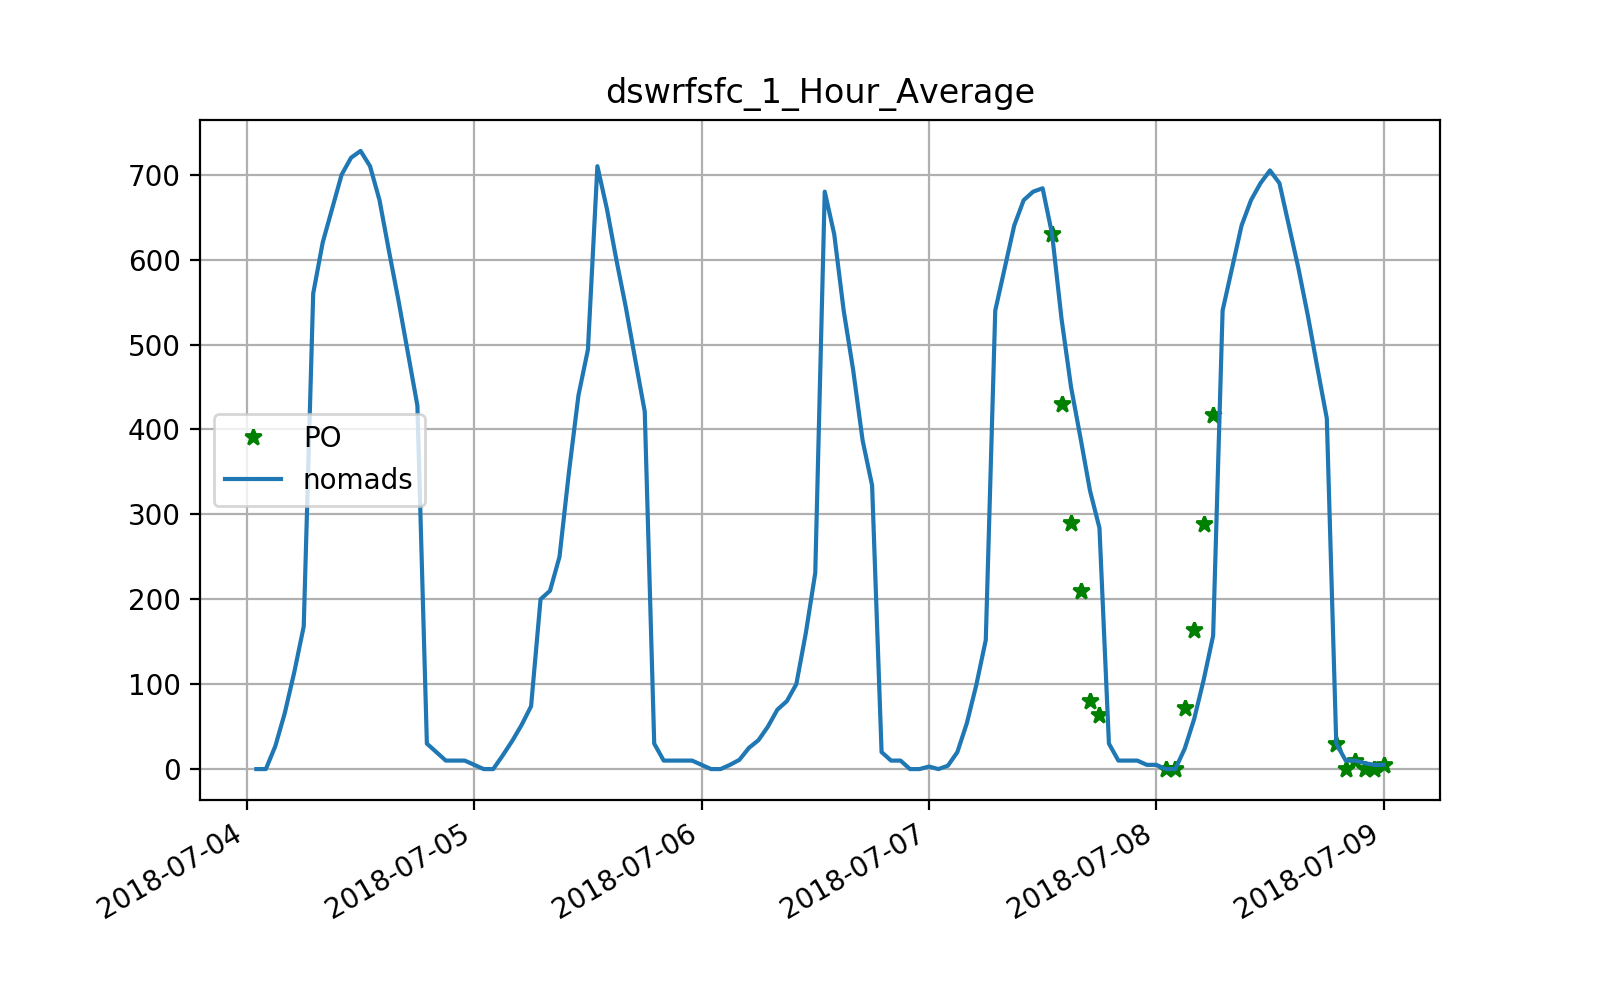

In [57]:
fig = plt.figure(figsize = (8,5))
plt.plot(PO_point_data_pd['time'].apply(dateutil.parser.parse)[:],PO_point_data_pd[PO_var_name][:],'*',color='green',label="PO")
plt.plot(nomads_testdata[0][:],nomads_testdata[1][:],label="nomads")
fig.autofmt_xdate()
plt.grid()
plt.legend()
plt.title(PO_var_name)
plt.show()

Now, looking at the graph, one might think that these two series of data do not match, but this impression is due to the fact that aggregation periods are different and when we take the integrals of both datasets, we see they are acutally the same or as close as possible, considering the relatively low numerical accuracy. It is also important to keep in mind here, that if you do not know the actual averaging period, one might easily use the 1 .. 6 hour mixed intervals as actual 1 h aggregated values. 

In [58]:
secnum = 12 ## add 6 or N x 6 to plot different sections
PO_time = list(PO_point_data_pd['time'][secnum+11:secnum+18])
PO_data = list(PO_point_data_pd[PO_var_name][secnum+12:secnum+18])
PO_data.insert(0,0.)
NOM_data = list(nomads_testdata[1][secnum+13:secnum+19])
NOM_time = list(nomads_testdata[0][secnum+13:secnum+19])
NOM_data.insert(0,0.)
xdata = list(range(len(PO_time)))
def draw_data_with_integrals(f):
    fig, ax = plt.subplots(figsize = (12,6))
    plt.plot(xdata,PO_data,'*', color='green',label = "PO")
    for jj in range(0,f):
        plt.fill_between(xdata[jj:jj+2],[0,0], [PO_data[jj+1], PO_data[jj+1]], alpha=0.3, hatch = "\\")
    plt.plot(xdata,NOM_data,label="nomads")
    plt.fill_between(xdata[0:f+1],np.zeros(f+1),np.ones(f+1) * NOM_data[f], color='red',alpha=0.3,hatch="/")
    plt.title("Integrated radiation from {0} to {1}".format(PO_time[f-1],PO_time[f]))
    plt.legend()
    plt.grid()
    ax.set_ylim([np.amin(PO_data) -10 , np.amax(PO_data)+10])
    plt.show()
widgets.interact(draw_data_with_integrals, f = (1,6))

<function __main__.draw_data_with_integrals>

Let's try to recompute the data on the fly and get the match between two data sources.

The average is computed as

$S_n = \frac{1}{n} \sum_i^n s_i$ 

$S_{n-1} = \frac{1}{n-1} \sum_i^{n-i} s_i$

$s_n = n S_n - (n-1) S_{n-1}$

While theoretically nice, one has to be careful with this equation. Original output data for weather models can be with low precision, in case of downwelling shortwave radiation, the accuracy is 10, meaning variable can have values 0, 10, 20, ...

We have observed a case, where original data has following values for 1h, 2h, 3h, 4h, 5h and 6h averages:

[0,0,0,0,10,0]

By using the equation given above, corresponding 1h averages will be

[0,0,0,0,50,-50]

which has two obvious problems. First is that values cannot be negative, second is that the 5'th hour average can actually have rather large range of values.

5 hour average value can be in range 

$5.1 .. 14.9$

This can result from first 4 hours being 4.9 and 5'th hour 5.9

$5.1 * 5 - 4 * 4.9 = 5.9$

or 

$14.9 * 5 - 4 * 0 = 74.5$


The possible lowest and highest values for accumulated radiation received at surface during the first five hours for original data are

$R_{max} = 5 h * 14.9 W m^{-2} = 74.5 Wh m^{-2}$

$R_{min} = 5 h * 5.1 W m^{-2} = 25.5 Wh m^{-2}$

The same values for recomputed data could be:

$R_{max} = 4 * 4.9 Wh m^{-2} + 54.5 Wh m^{-2} = 74.1 Wh m^{-2}$

$R_{min} = 4* 0 Wh m^{-2} + 45.1 Wh m^{-2} = 45.1 Wh m^{-2}$

Now let's apply the transformation to nomads data and see how close we can get.

In [59]:
def normalize_nomads_average(indata):
    outdata = np.copy(indata)
    outdata[1:][1::6] = 2 * indata[1:][1::6] - 1 * indata[1:][0::6]
    outdata[1:][2::6] = 3 * indata[1:][2::6] - 2 * indata[1:][1::6]
    outdata[1:][3::6] = 4 * indata[1:][3::6] - 3 * indata[1:][2::6]
    outdata[1:][4::6] = 5 * indata[1:][4::6] - 4 * indata[1:][3::6]
    outdata[1:][5::6] = 6 * indata[1:][5::6] - 5 * indata[1:][4::6]
    return outdata

<IPython.core.display.Javascript object>


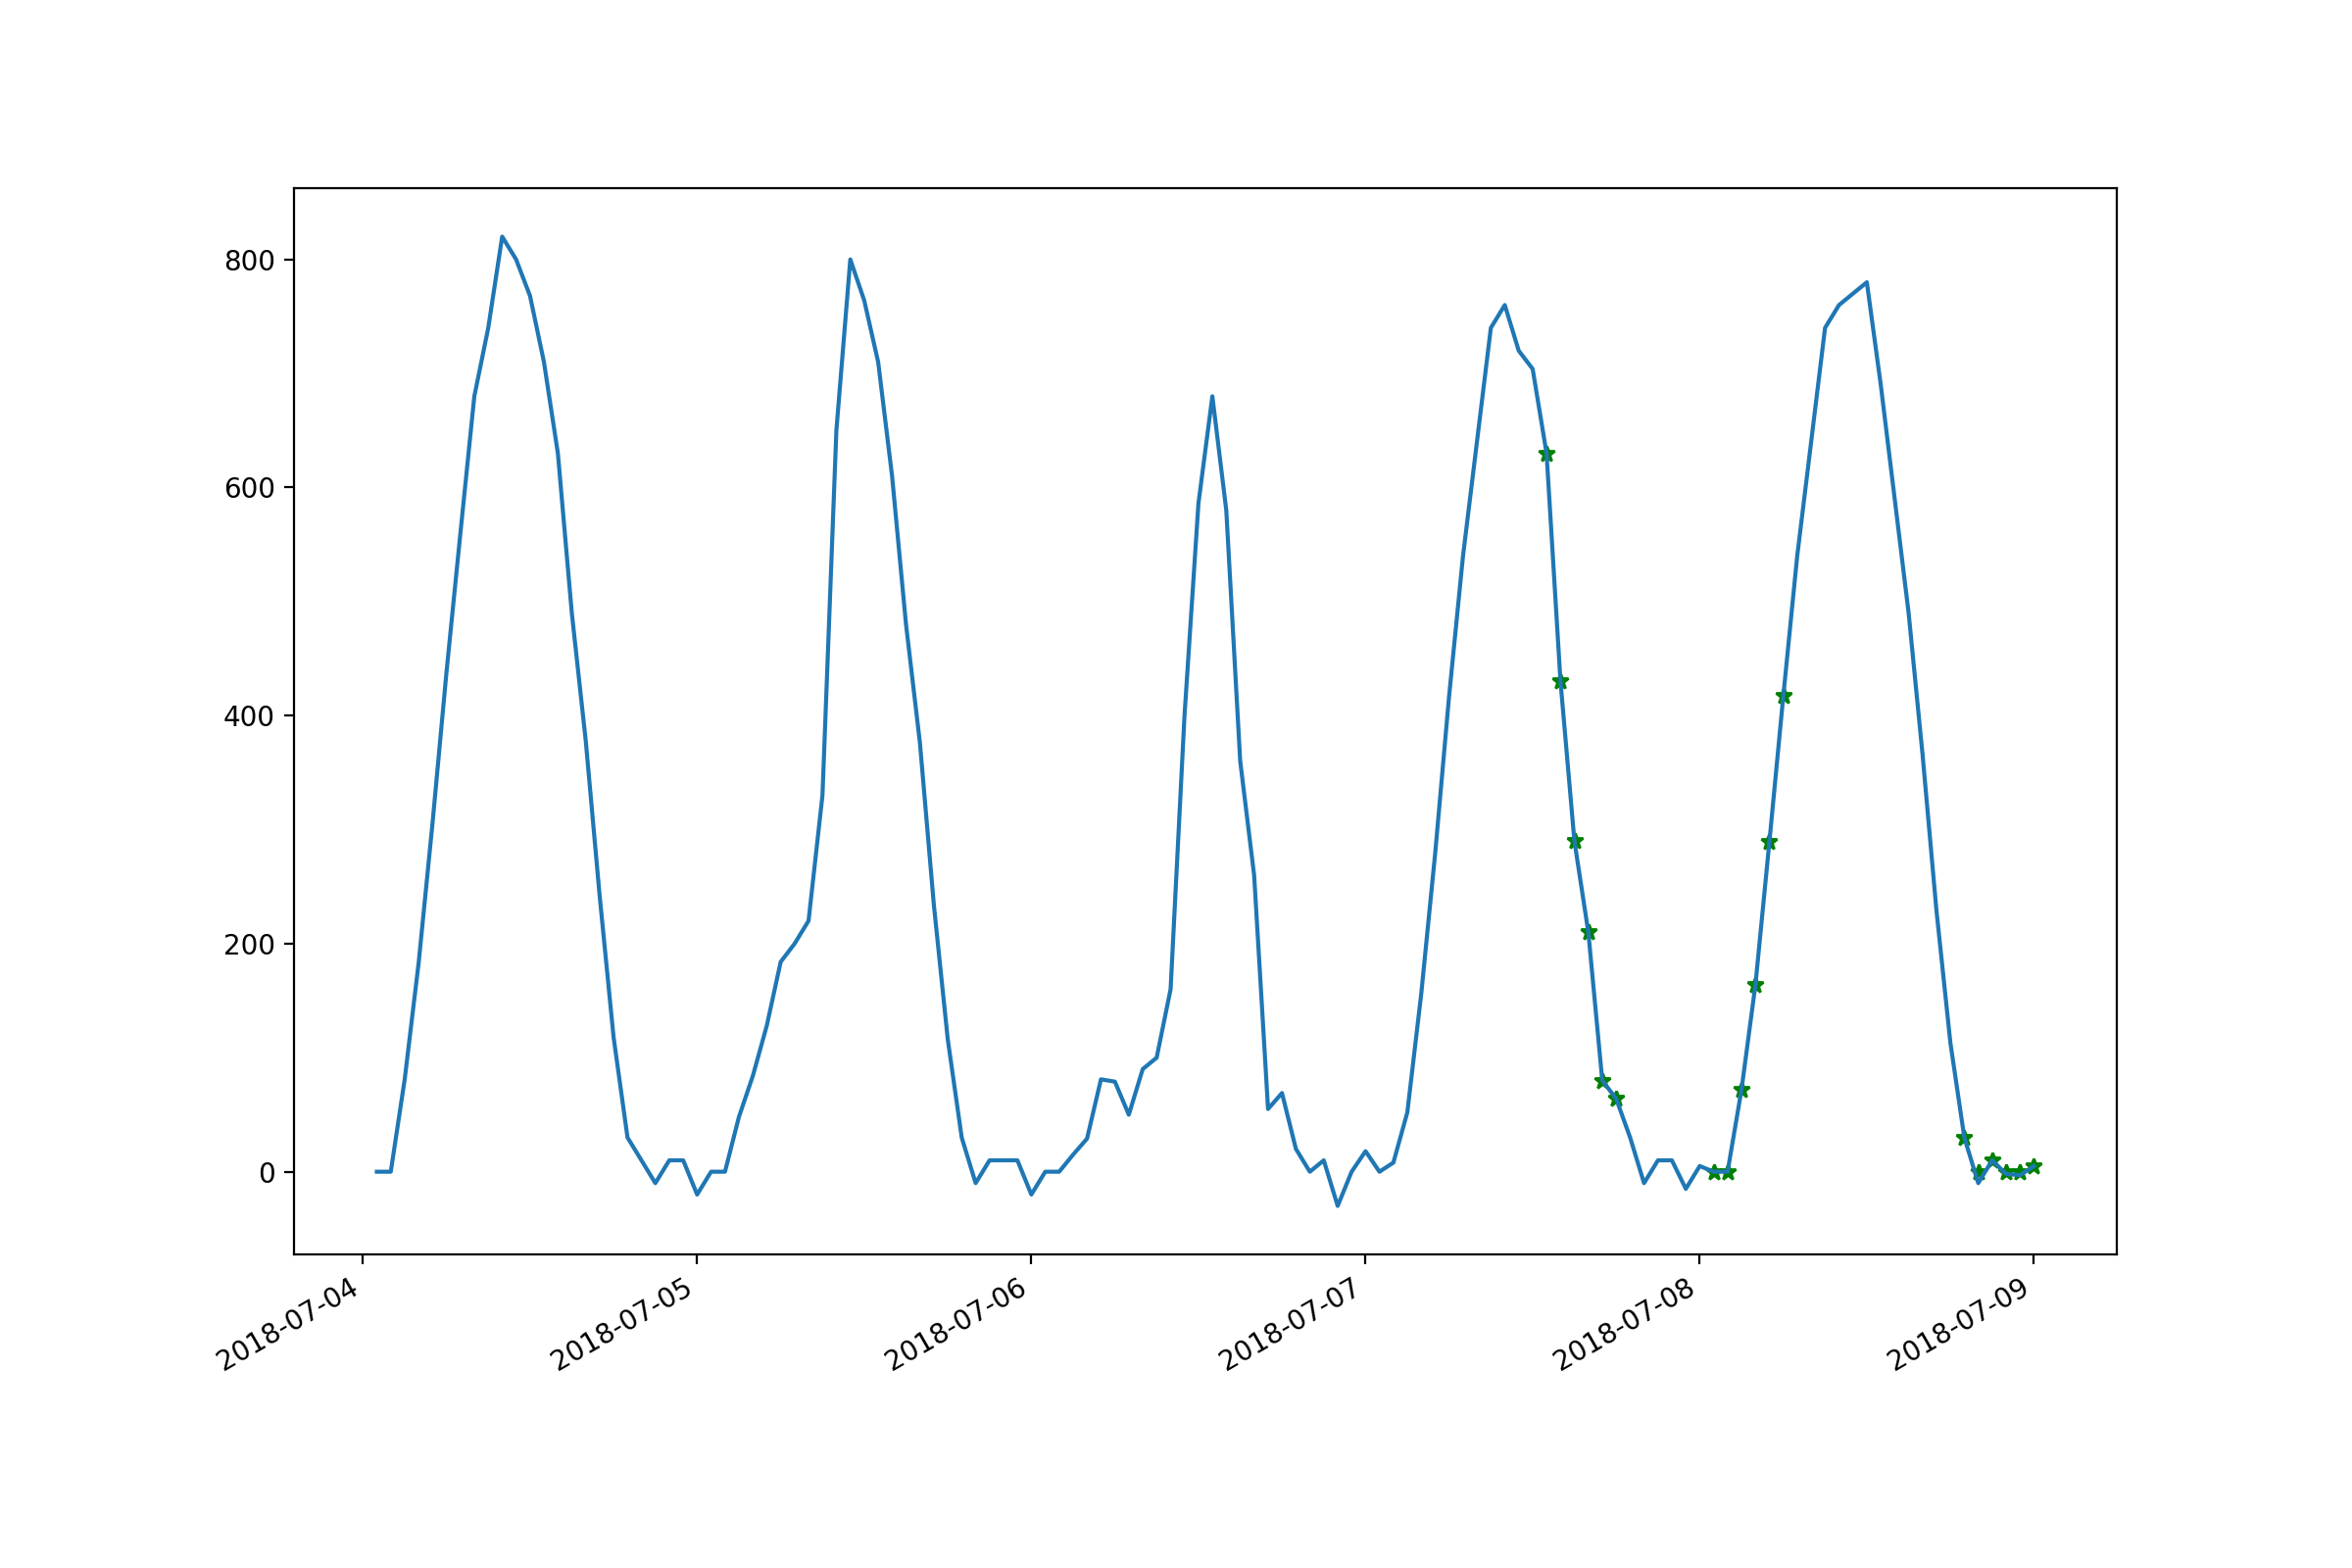

In [60]:
fig = plt.figure(figsize = (12,8))
plt.plot(PO_point_data_pd['time'].apply(dateutil.parser.parse),PO_point_data_pd[PO_var_name],'*',color='green')
plt.plot(nomads_testdata[0][1:],normalize_nomads_average(nomads_testdata[1])[1:])
fig.autofmt_xdate()
plt.show()

Now we see that the transformation we derived before can result in negative values, which we have simply filtered out in PO data. 

We hope that these examples help you to build your own weather forecast dashboards with Jupyter or some other tool, and that you can better understand the tricks in using the model data, which are caused by limited numerical accuracy or strange aggregation periods.